In [1]:
import sys
sys.path.append("./../..")

from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single
from scipy.optimize import curve_fit

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch

In [2]:
@jit
def OrnsteinUhlenbeck(param, n_sim, dt = 0.01, TotalT = 1):
    k = param[0]
    D = param[1]
    time_steps_amount = np.int64(TotalT/dt)

    x = np.zeros((1, n_sim))
    x_tilde = np.zeros((1, n_sim))
    x_trace = np.zeros((n_sim, time_steps_amount))
    
    for t in np.arange(0, time_steps_amount):
        
        x_tilde[:] = x[:] + -k * x[:] * dt + np.sqrt(2*D) * np.random.normal(0, np.sqrt(dt), size = (1,n_sim))
        x[:] = x_tilde + (+k * x[:] - k*x_tilde[:])*dt /2
        x_trace[:,t] = x[:,]
    
    return x_trace


def GenerateDataForSBI(n_sim, prior_limits, dt = 0.01, TotalT = 1):
    # Generate data
    params = np.array([np.random.uniform(prior_limits["k"][0], prior_limits["k"][1], n_sim), np.random.uniform(prior_limits["D"][0], prior_limits["D"][1], n_sim)])
    trace = OrnsteinUhlenbeck(params, n_sim, dt, TotalT)
    trace = torch.tensor(np.array(trace)).float()
    params = torch.tensor(np.array(params)).float()
    
    return trace, params.T
    

In [3]:
dt = 1e-2 # Time Step in seconds
TotalT = 1000 # Total Time in seconds
param = [2., 3.] # [k, D]
t = np.arange(0, TotalT, dt)
prior_limits = {"k": [0.0,5.0],
                "D": [0.0,5.0]}

In [4]:
# Run the simulation
x_trace = OrnsteinUhlenbeck(param, n_sim = 10, dt = dt, TotalT = TotalT)

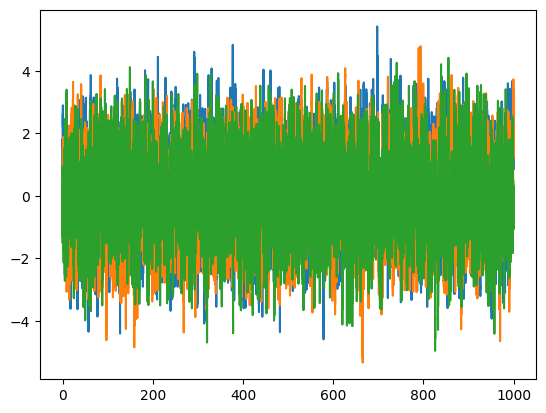

In [5]:
# Plot the trace
fig, ax = plt.subplots()
ax.plot(t[:], x_trace[0,:])
ax.plot(t[:], x_trace[1,:])
ax.plot(t[:], x_trace[2,:]);

In [6]:
# Compute interesting descriptors
mean = np.mean(x_trace)
std = np.std(x_trace)
mean_x_squared = np.mean(x_trace**2)

print(f"Mean: {mean:.2f}")
print(f"Standard Deviation: {std:.2f}")
print(f"Mean of x^2: {mean_x_squared:.2f}")

Mean: -0.02
Standard Deviation: 1.22
Mean of x^2: 1.49


Fitted Autocorrelation Decay Time: 0.53
Fitted Autocorrelation Amplitude: 1.49
True Autocorrelation Decay Time: 0.50
True Autocorrelation Amplitude: 1.50


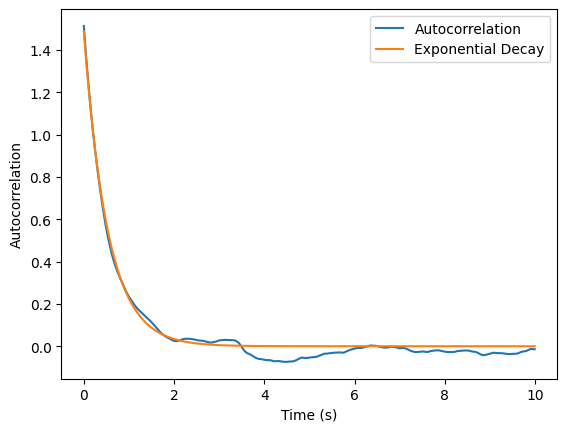

In [7]:
# Autocorrelation
autocorrelation = stat_corr_single(x_trace[0],DeltaT = dt)
## Fit autocorrelation with exponential decay
def exp_decay(t, A, tau):
    return A*np.exp(-t/tau)
popt, pcov = curve_fit(exp_decay, t[:len(autocorrelation)], autocorrelation, p0 = [1, 1])
A, tau = popt
print(f"Fitted Autocorrelation Decay Time: {tau:.2f}")
print(f"Fitted Autocorrelation Amplitude: {A:.2f}")
print(f"True Autocorrelation Decay Time: {1/param[0]:.2f}")
print(f"True Autocorrelation Amplitude: {param[1]/param[0]:.2f}")

## Plot the autocorrelation

fig, ax = plt.subplots()
ax.plot(t[:1000], autocorrelation[:1000], label = "Autocorrelation")
ax.plot(t[:1000], exp_decay(t[:1000], A, tau), label = "Exponential Decay")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Autocorrelation")
ax.legend();


# SBI with the raw trace

In [8]:
# Setup SBI boilerplate
prior_box = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

In [9]:
# Generate data in SBI format
n_sim = 14000
trace, params = GenerateDataForSBI(n_sim, prior_limits, dt = dt, TotalT = TotalT)
trace = trace.reshape(n_sim, len(t))

In [10]:
# Train density estimator and extrace the posterior
inference = infer.append_simulations(params, trace)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 21 epochs.

In [11]:
# Generate test data
n_test = 1
trace_test, params_test = GenerateDataForSBI(n_test, prior_limits, dt = dt, TotalT = TotalT)

python(12449) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

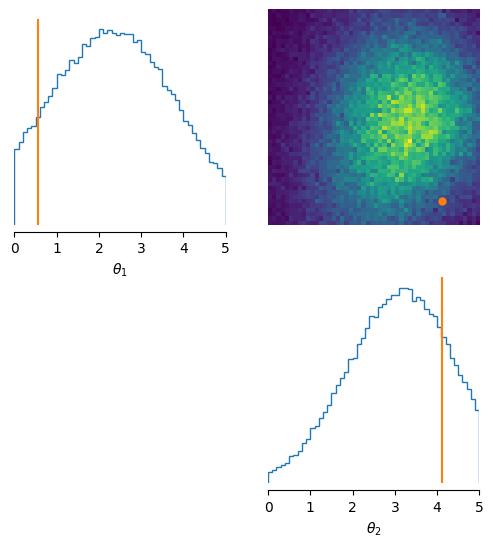

In [12]:
# Use test data to check if the posterior is working
samples = posterior.sample((100000,), x=trace_test.reshape(n_test, len(t)))
_ = analysis.pairplot(samples, points=params_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])

# SBI with autocorrelation

In [14]:
# Generate the autocorrelation
autocorrelation = np.zeros_like(trace)

for i in tqdm(np.arange(n_sim)):
    autocorrelation[i,:] = stat_corr_single(np.array(trace[i,:]),DeltaT = dt)
    
autocorrelation = torch.tensor(autocorrelation).float()

100%|██████████| 14000/14000 [03:58<00:00, 58.66it/s]


In [15]:
# Setup SBI boilerplate
prior_box = utils.BoxUniform(low=torch.tensor([0.0, 0.0]), high=torch.tensor([5.0, 5.0]))
prior, num_parameters, prior_returns_numpy = process_prior(prior_box)
infer = SNPE(prior=prior)

In [16]:
# Train density estimator and extrace the posterior
inference = infer.append_simulations(params, autocorrelation[:,:1000])
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 135 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

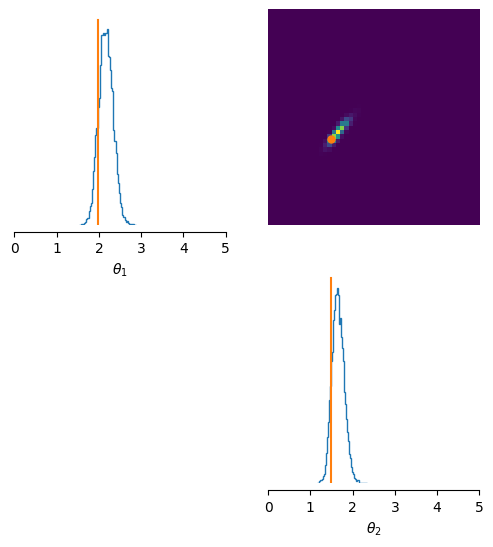

In [37]:
# Generate test data
n_test = 1
trace_test, params_test = GenerateDataForSBI(n_test, prior_limits, dt = dt, TotalT = TotalT)
autocorr_test = stat_corr_single(np.array(trace_test[0,:1000]),DeltaT = dt)
# Use test data to check if the posterior is working
samples = posterior.sample((10000,), x=autocorr_test[:1000])
_ = analysis.pairplot(samples, points=params_test, limits=[[0.0, 5.], [0, 5.]], figsize=(6, 6), labels=[r"$\theta_1$", r"$\theta_2$"])